In [21]:
%matplotlib inline
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16
mpl.rcParams['font.family'] = 'sans-serif'

Problem 3: Reproducing Salpter (1955)

From Table 2, we can get the reported $\log(M/M_\odot)$ and $\log\xi$ in the paper. Note that what is reported in Table 2 is $\log(M/M_\odot)+1$ and $\log\xi+10$, so we subtract out the constants.

In [2]:
logM_s55 = -1.+np.array([2.23,2.08,1.93,1.78,1.63,1.48,1.33,1.2,1.09,1.,.93,.86,.8,.74,.68,.62,.56,.5])
logP_s55 = -10.+np.array([6.63,7.1,7.36,7.52,7.72,8.,7.98,7.98,8.32,8.5,8.6,8.7,8.83,8.97,9.04,9.13,9.2,9.22])

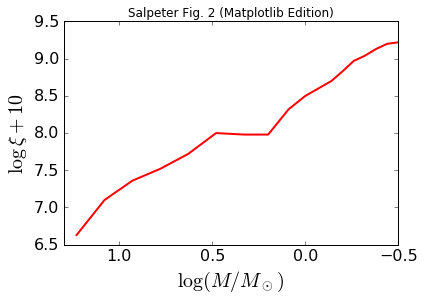

In [15]:
plt.plot(logM_s55,logP_s55+10,color='red',lw=2)
plt.xlim(1.3,-.5)
plt.xlabel(r'$\log(M/M_\odot)$')
plt.ylabel(r'$\log\,\xi+10$')
plt.title("Salpeter Fig. 2 (Matplotlib Edition)")

With the advent of technology, we no longer need to chi-by-eye! Instead, we chi-by-scipy.

Namely, since we are given masses and IMF data points in log-log space, we can perform a linear fit to the data, which is equivalent to a power law. Thus, we want to find best-fitting parameters $(m,b)$ for the functional
\begin{align}
\vec{y}-m\vec{x}-b=0
\end{align}
We turn this into a chi-squared minimization problem by minimizing the square of the left-hand side:

\begin{align}
F(m,b)=\sum_i\left(y_i-mx_i-b\right)^2
\end{align}

and so our problem turns into a minimization scheme:

\begin{align}
{\rm minimize}\,\, F(m,b)
\end{align}

for arguments $(m,b)$. We use Powell minimization as provided for in the scipy optimize package. For the Salpeter data, we find best-fit parameters $m=-1.4, b=-1.47$. Identifying $m$ as $\alpha$, we thus have the true (according to minimization) IMF slope of $\alpha=1.4$ rather than $1.35$, a roughly $4\%$ difference.

In [23]:
def chisq_func(xi,yi,m,b):
    chisq_val = np.sum((yi-m*xi-b)**2)
    return chisq_val

def min_func(theta):
    return chisq_func(logM_s55,logP_s55,theta[0],theta[1])

In [32]:
res = scipy.optimize.minimize(min_func,(-1.,0.),method='Powell')
print(res.x)

[-1.40350148 -1.46510861]


Next we try to infer the IMF slope using emcee. We can choose a flat prior with the condition that $\alpha$ be nonnegative. The likelihood function is achieved by comparing the derived IMF values at a given mass $\xi(m)$ with that from a power-law

\begin{align}
\xi=cm^{-\alpha}
\end{align}
or in log-space
\begin{align}
\ln\,\xi=-\alpha\ln\,m+\ln\,c
\end{align}
The probability for getting $(m_i,\xi_i)$ given parameters $(\alpha,c)$ can be defined as
\begin{align}
p(m_i,\xi_i|\theta)&=\Delta(\ln\xi)_i\\
&= -\alpha\ln\,m_i+\ln\,c-\ln\xi_i
\end{align}
and so the likelihood for given data $(\vec{m},\vec{\xi})$ is
\begin{align}
\ln P(\vec{m},\vec{xi}|\theta)=-\sum_i(\Delta\ln\xi)_i^2
\end{align}
where the minus sign indicates we are trying to find the maximum likelihood, and the square of the difference indicates we are interested in absolute differences.

In [73]:
def lnprior(theta):
    alpha, c = theta
    if alpha < 0:
        return -np.inf
    return 0.0

def lnlikelihood(theta,data):
    mass, xi = data
    alpha, c = theta
    return -np.sum((alpha*mass+c-xi)**2)

def lnposterior(theta,data):
    return lnprior(theta) + lnlikelihood(data,theta)

In [74]:
data = [logM_s55,logP_s55]

nwalkers = 50
ndim = 2
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnposterior,args=[data])
pos, prob, state = sampler.run_mcmc(p0,100)
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos,2000)

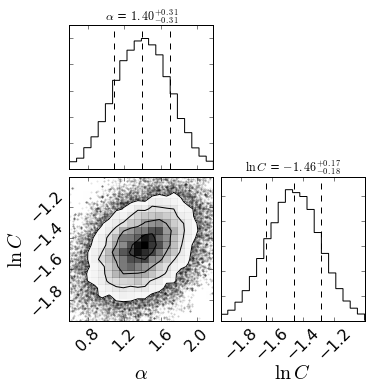

In [75]:
fig = corner.corner(sampler.flatchain,range=[0.99,0.99],quantiles=[.16,.5,.84],labels=[r'$\alpha$',r'$\ln\,C$'],show_titles=True)

Hence, we infer an IMF slope with emcee of 1.40, identical (within errors we are considering) to the chi-squared optimization problem above.